In [5]:
pip install pyarrow fastparquet

   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   -- ------------------------------------- 1.8/28.0 MB 10.1 MB/s eta 0:00:03
   ------------ --------------------------- 8.9/28.0 MB 21.3 MB/s eta 0:00:01
   --------------------------- ------------ 19.1/28.0 MB 27.5 MB/s eta 0:00:01
   ------------------------------------- -- 26.0/28.0 MB 29.4 MB/s eta 0:00:01
   ---------------------------------------- 28.0/28.0 MB 25.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/673.3 kB ? eta -:--:--
   ---------------------------------------- 673.3/673.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install --upgrade pandas pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
pip install --force-reinstall pyarrow==16.1.0

  Using cached numpy-2.3.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.8 MB ? eta -:--:--
    --------------------------------------- 0.5/25.8 MB 1.1 MB/s eta 0:00:23
   - -------------------------------------- 0.8/25.8 MB 1.4 MB/s eta 0:00:18
   - -------------------------------------- 1.0/25.8 MB 1.6 MB/s eta 0:00:16
   -- ------------------------------------- 1.8/25.8 MB 1.8 MB/s eta 0:00:14
   --- ------------------------------------ 2.4/25.8 MB 2.0 MB/s eta 0:00:12
   ---- ----------------------------------- 3.1/25.8 MB 2.2 MB/s eta 0:00:11
   ------ --------------------------------- 3.9/25.8 MB 2.4 MB/s eta 0:00:10
   ------- -------------------------------- 4.7/25.8 MB 2.6 MB/s eta 0:00:09
   -------- ------------------------------- 5.5/25.8 MB 2.7 MB/s eta 0:00:08
   ---------- ----------------------------- 6.6/25.8 MB 2.9 MB/s eta 0:00:07
   ----------- -----

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = Path('C:/Users/sande/OneDrive/Desktop/Deep Learning/Time Series Forecasting/egrid_all_plants_1996-2023.parquet')
TARGET_YEAR = 2023
CONTAMINATION = 0.05
RANDOM_STATE = 42

ANOMALY DETECTION - PRODUCTION RUN
Loading 2023 data...
Loaded 12,613 plants

Analyzing 3,273 plants with complete data

[1/4] Running Isolation Forest...
  Found 164 anomalies (5.0%)

[2/4] Running Local Outlier Factor...
  Found 164 anomalies (5.0%)

[3/4] Running Robust Covariance...
  Found 164 anomalies (5.0%)

[5/4] Creating Ensemble...
  Ensemble flagged 76 plants (2.3%)

ANOMALY ANALYSIS
--------------------------------------------------------------------------------
Total anomalies: 76 (2.3%)
Normal plants: 3,197

Comparison (median values):
Metric                         Normal          Anomalies       Difference
--------------------------------------------------------------------------------
carbon_intensity               0.5568          2.9120          +423.0%
capacity_factor                0.2054          0.0014          -99.3%
log_generation                 10.6338         6.6234          -37.7%

Top 5 Most Anomalous Plants:
-----------------------------------------------

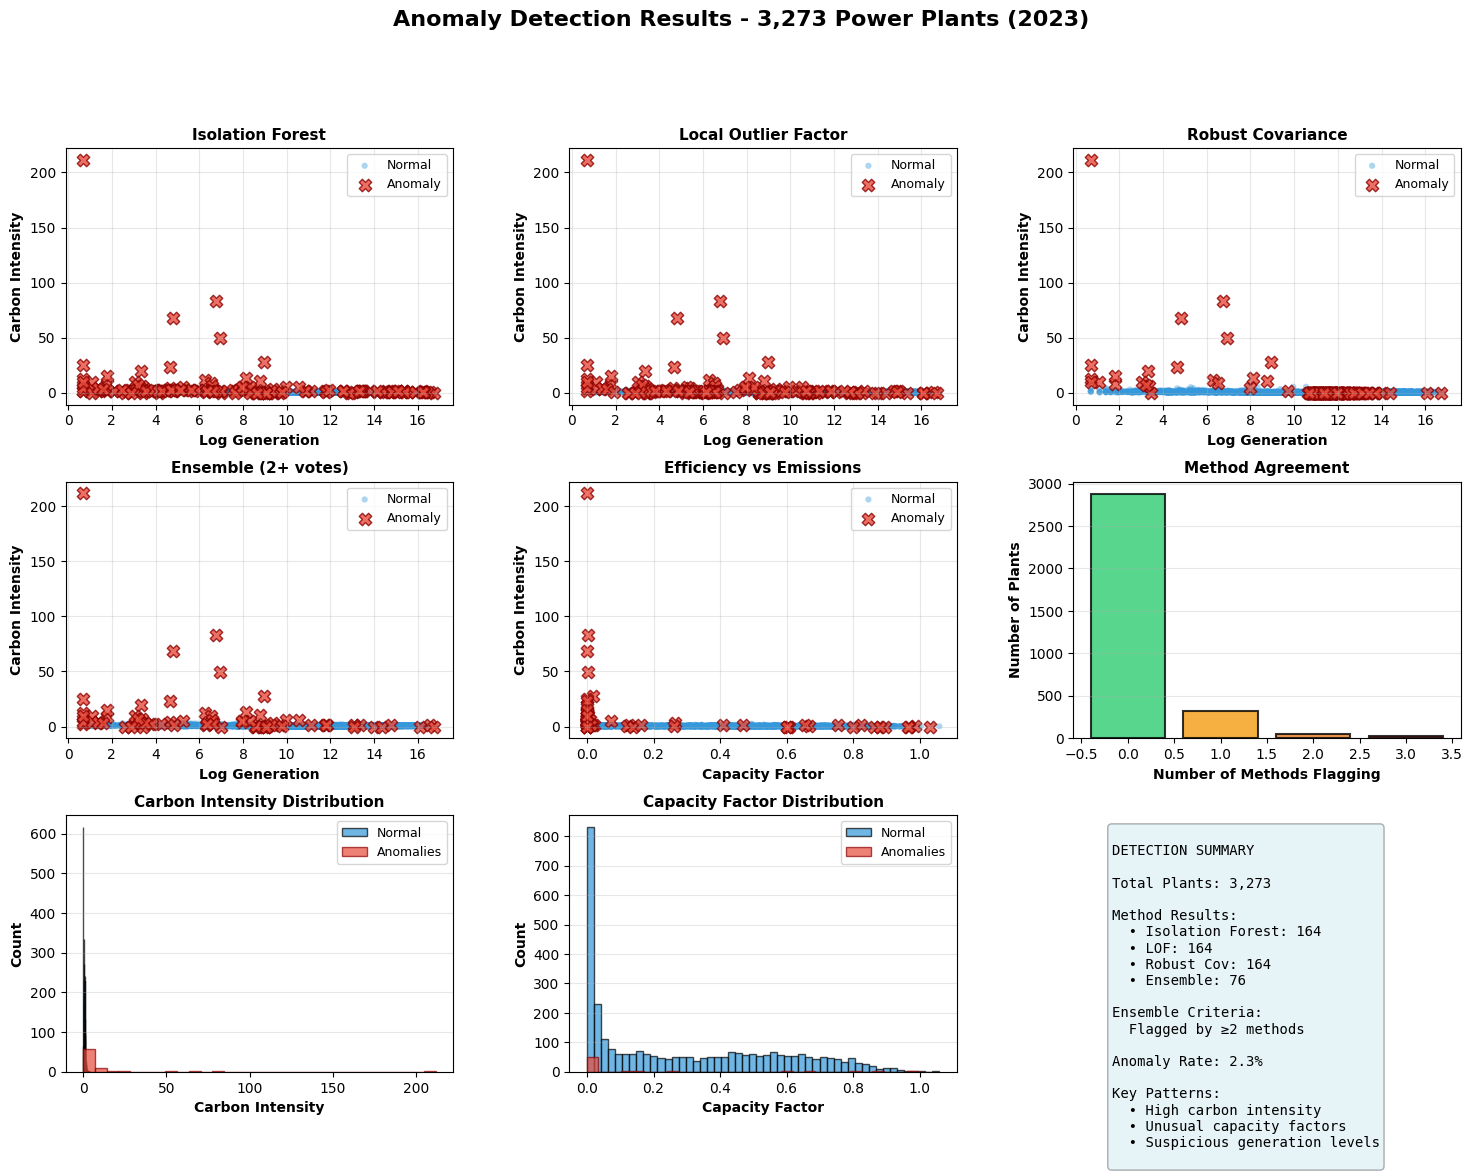

In [12]:
def load_and_prepare_data(year):
    print(f"Loading {year} data...")
    plants = pd.read_parquet(DATA_PATH)
    df = plants[plants['data_year'] == year].copy()
    gen = pd.to_numeric(df['Plant annual net generation (MWh)'], errors='coerce')
    co2 = pd.to_numeric(df['Plant annual CO2 emissions (tons)'],errors='coerce')
    nox = pd.to_numeric(df[[c for c in df.columns if 'NOx' in c and 'annual' in c and 'tons' in c][0]],errors='coerce')
    so2 = pd.to_numeric(df[[c for c in df.columns if 'SO2' in c and 'annual' in c and 'tons' in c][0]],errors='coerce')
    capacity = pd.to_numeric(df['Plant nameplate capacity (MW)'], errors='coerce')
    df['carbon_intensity'] = np.where(gen>0, co2/gen, np.nan)
    df['nox_intensity'] = np.where(gen>0, nox/gen, np.nan)
    df['so2_intensity'] = np.where(gen>0, so2/gen, np.nan)
    df['capacity_factor'] = np.where(capacity>0, gen/(capacity*8760),np.nan)
    df['log_generation'] = np.log1p(gen)
    df['log_co2'] = np.log1p(co2)
    print(f"Loaded {len(df):,} plants")
    return df

def detect_anomalies_isolation_forest(X, contamination=0.05):
    print("\n[1/4] Running Isolation Forest...")
    model = IsolationForest(
        contamination=contamination,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=200
    )
    predictions = model.fit_predict(X)
    scores = model.score_samples(X)
    n_anomalies = (predictions == -1).sum()
    print(f"  Found {n_anomalies:,} anomalies ({n_anomalies/len(X)*100:.1f}%)")
    
    return predictions, scores

def detect_anomalies_lof(X, contamination=0.05):
    """Local Outlier Factor anomaly detection"""
    print("\n[2/4] Running Local Outlier Factor...")
    model = LocalOutlierFactor(
        contamination=contamination,
        n_neighbors=20,
        n_jobs=-1
    )
    predictions = model.fit_predict(X)
    scores = model.negative_outlier_factor_
    n_anomalies = (predictions == -1).sum()
    print(f"  Found {n_anomalies:,} anomalies ({n_anomalies/len(X)*100:.1f}%)")
    return predictions, scores

def detect_anomalies_robust_covariance(X, contamination=0.05):
    """Robust Covariance (Elliptic Envelope) anomaly detection"""
    print("\n[3/4] Running Robust Covariance...")
    
    model = EllipticEnvelope(
        contamination=contamination,
        random_state=RANDOM_STATE,
        support_fraction=0.8
    )
    
    predictions = model.fit_predict(X)
    scores = model.score_samples(X)
    
    n_anomalies = (predictions == -1).sum()
    print(f"  Found {n_anomalies:,} anomalies ({n_anomalies/len(X)*100:.1f}%)")
    
    return predictions, scores

def statistical_outliers(df, features, n_std=3):
    """Statistical outlier detection (Z-score)"""
    print("\n[4/4] Running Statistical Outlier Detection...")
    outliers = np.zeros(len(df),dtype=bool)
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        z_scores = np.abs((df[feature]-mean)/std)
        outliers |= (z_scores > n_std)
    n_outliers = outliers.sum()
    print(f"  Found {n_outliers:,} outliers ({n_outliers/len(df)*100:.1f}%)")
    return outliers

def ensemble_anomalies(predictions_list, threshold=2):
    votes = np.sum([p==-1 for p in predictions_list],axis=0)
    ensemble_anomalies = votes>=threshold
    return ensemble_anomalies

def analyze_anomalies(df, anomaly_mask):
    """Analyze characteristics of detected anomalies"""
    print("\nANOMALY ANALYSIS")
    print("-" * 80)
    anomalies = df[anomaly_mask]
    normal = df[~anomaly_mask]
    print(f"Total anomalies: {len(anomalies):,} ({len(anomalies)/len(df)*100:.1f}%)")
    print(f"Normal plants: {len(normal):,}")
    print("\nComparison (median values):")
    print(f"{'Metric':<30} {'Normal':<15} {'Anomalies':<15} {'Difference'}")
    print("-" * 80)
    metrics = ['carbon_intensity', 'capacity_factor', 'log_generation']
    for metric in metrics:
        normal_val = normal[metric].median()
        anomaly_val = anomalies[metric].median()
        diff = ((anomaly_val - normal_val)/normal_val*100) if normal_val!=0 else 0
        print(f"{metric:<30} {normal_val:<15.4f} {anomaly_val:<15.4f} {diff:+.1f}%")
    print("\nTop 5 Most Anomalous Plants:")
    print("-" * 80)
    top_anomalies = anomalies.nlargest(5, 'carbon_intensity')
    for idx, row in top_anomalies.iterrows():
        plant_name = row.get('Plant name', 'Unknown')
        state = row.get('Plant state abbreviation', '??')
        carbon = row['carbon_intensity']
        cap_factor = row['capacity_factor']
        print(f"  {plant_name[:40]:<40} ({state}) - CI: {carbon:.3f}, CF: {cap_factor:.3f}")

def visualize_results(df, iso_pred, lof_pred, cov_pred, ensemble_mask, features):
    """Create comprehensive visualization"""
    print("\nGenerating visualizations...")
    fig = plt.figure(figsize=(18,12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    def plot_scatter(ax, x_feat, y_feat, predictions, title):
        normal_mask = predictions == 1
        anomaly_mask = predictions == -1
        ax.scatter(df.loc[normal_mask, x_feat], df.loc[normal_mask, y_feat],
                  c='#3498db', alpha=0.4, s=20, label='Normal', edgecolors='None')
        ax.scatter(df.loc[anomaly_mask, x_feat], df.loc[anomaly_mask, y_feat],
                  c='#e74c3c', alpha=0.8, s=80, marker='X', label='Anomaly', edgecolors='darkred', linewidths=1)
        ax.set_xlabel(x_feat.replace('_',' ').title(),fontsize=10, fontweight='bold')
        ax.set_ylabel(y_feat.replace('_',' ').title(), fontsize=10, fontweight='bold')
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    ax1 = fig.add_subplot(gs[0,0])
    plot_scatter(ax1, 'log_generation', 'carbon_intensity', iso_pred, 'Isolation Forest')
    ax2 = fig.add_subplot(gs[0,1])
    plot_scatter(ax2, 'log_generation', 'carbon_intensity', lof_pred, 'Local Outlier Factor')
    ax3 = fig.add_subplot(gs[0,2])
    plot_scatter(ax3, 'log_generation', 'carbon_intensity', cov_pred, 'Robust Covariance')
    ax4 = fig.add_subplot(gs[1,0])
    ensemble_pred = np.where(ensemble_mask, -1, 1)
    plot_scatter(ax4, 'log_generation', 'carbon_intensity', ensemble_pred, 'Ensemble (2+ votes)')
    ax5 = fig.add_subplot(gs[1,1])
    plot_scatter(ax5, 'capacity_factor', 'carbon_intensity', ensemble_pred, 'Efficiency vs Emissions')
    ax6 = fig.add_subplot(gs[1,2])
    votes = np.sum([iso_pred==-1, lof_pred==-1, cov_pred==-1], axis=0)
    vote_counts = pd.Series(votes).value_counts().sort_index()
    ax6.bar(vote_counts.index, vote_counts.values, color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'],
           alpha=0.8, edgecolor='black', linewidth=1.5)
    ax6.set_xlabel('Number of Methods Flagging', fontsize=10, fontweight='bold')
    ax6.set_ylabel('Number of Plants', fontsize=10, fontweight='bold')
    ax6.set_title('Method Agreement', fontsize=11, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    ax7 = fig.add_subplot(gs[2,0])
    ax7.hist(df.loc[~ensemble_mask, 'carbon_intensity'], bins=50, alpha=0.7,
            color='#3498db', label='Normal', edgecolor='black')
    ax7.hist(df.loc[ensemble_mask, 'carbon_intensity'], bins=30, alpha=0.7, 
            color='#e74c3c', label='Anomalies', edgecolor='darkred')
    ax7.set_xlabel('Carbon Intensity', fontsize=10, fontweight='bold')
    ax7.set_ylabel('Count', fontsize=10, fontweight='bold')
    ax7.set_title('Carbon Intensity Distribution', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3, axis='y')
    ax8 = fig.add_subplot(gs[2,1])
    ax8.hist(df.loc[~ensemble_mask, 'capacity_factor'], bins=50, alpha=0.7, 
            color='#3498db', label='Normal', edgecolor='black')
    ax8.hist(df.loc[ensemble_mask, 'capacity_factor'], bins=30, alpha=0.7, 
            color='#e74c3c', label='Anomalies', edgecolor='darkred')
    ax8.set_xlabel('Capacity Factor', fontsize=10, fontweight='bold')
    ax8.set_ylabel('Count', fontsize=10, fontweight='bold')
    ax8.set_title('Capacity Factor Distribution', fontsize=11, fontweight='bold')
    ax8.legend(fontsize=9)
    ax8.grid(True, alpha=0.3, axis='y')
    ax9 = fig.add_subplot(gs[2,2])
    ax9.axis('off')
    summary_text = f"""
DETECTION SUMMARY

Total Plants: {len(df):,}

Method Results:
  • Isolation Forest: {(iso_pred == -1).sum():,}
  • LOF: {(lof_pred == -1).sum():,}
  • Robust Cov: {(cov_pred == -1).sum():,}
  • Ensemble: {ensemble_mask.sum():,}

Ensemble Criteria:
  Flagged by ≥2 methods

Anomaly Rate: {ensemble_mask.sum()/len(df)*100:.1f}%

Key Patterns:
  • High carbon intensity
  • Unusual capacity factors
  • Suspicious generation levels
    """
    ax9.text(0.1, 0.95, summary_text, transform=ax9.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    plt.suptitle(f'Anomaly Detection Results - {len(df):,} Power Plants ({TARGET_YEAR})',
                fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('02_anomaly_detection_results.png', dpi=300, bbox_inches='tight')
    print(" Saved: 02_anomaly_detection_results.png")

def export_anomalies(df, anomaly_mask, output_path='anomalies_flagged.csv'):
    anomalies = df[anomaly_mask].copy()
    export_cols = ['Plant name', 'Plant state abbreviation', 'Plant primary fuel category',
                  'carbon_intensity', 'capacity_factor', 'log_generation']
    export_cols = [c for c in export_cols if c in anomalies.columns]
    anomalies[export_cols].to_csv(output_path, index=False)
    print(f'\nExported {len(anomalies)} anomalies to: {output_path}')

def main():
    """Main execution"""
    print("=" * 80)
    print("ANOMALY DETECTION - PRODUCTION RUN")
    print("=" * 80)
    df = load_and_prepare_data(TARGET_YEAR)
    features = ['log_generation', 'log_co2', 'carbon_intensity',
               'capacity_factor', 'nox_intensity', 'so2_intensity']
    X = df[features].dropna()
    df_clean = df.loc[X.index].copy()
    print(f"\nAnalyzing {len(X):,} plants with complete data")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    iso_pred, iso_scores = detect_anomalies_isolation_forest(X_scaled, CONTAMINATION)
    lof_pred, lof_scores = detect_anomalies_lof(X_scaled, CONTAMINATION)
    cov_pred, cov_scores = detect_anomalies_robust_covariance(X_scaled, CONTAMINATION)
    print("\n[5/4] Creating Ensemble...")
    ensemble_mask = ensemble_anomalies([iso_pred, lof_pred, cov_pred], threshold=2)
    print(f"  Ensemble flagged {ensemble_mask.sum():,} plants ({ensemble_mask.sum()/len(X)*100:.1f}%)")
    analyze_anomalies(df_clean, ensemble_mask)
    visualize_results(df_clean, iso_pred, lof_pred, cov_pred, ensemble_mask, features)
    export_anomalies(df_clean, ensemble_mask)
    print("\n" + "=" * 80)
    print("✓ Complete!")
    print("=" * 80)
    return {
        'data': df_clean,
        'anomalies': df_clean[ensemble_mask],
        'predictions': {
            'isolation_forest': iso_pred,
            'lof': lof_pred,
            'robust_cov': cov_pred,
            'ensemble': ensemble_mask
        }
    }

if __name__ == '__main__':
    results = main()

In [1]:
import pandas as pd
import pyarrow as pa
print("pandas:", pd.__version__)
print("pyarrow:", pa.__version__)

pandas: 2.3.3
pyarrow: 16.1.0
